In [1]:
import numpy as np
import cv2
import torch
import laspy
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import time
from numba import jit

In [2]:
import sys
sys.path.append(".")
from files import *

# Agisoft

In [6]:
cameras = read_camera_parameters_agisoft("../../data/box_canyon_export/camera_params.xml")

In [7]:
extrinsic_matrix = cameras['DJI_0247.JPG']
camera_intrinsics = cameras['K']
image_height = cameras['height']
image_width = cameras['width']


print(extrinsic_matrix)
print(camera_intrinsics)
print(image_height, image_width)

[[-5.97573017e-01 -7.91932875e-01  1.25494270e-01  4.32761423e+05]
 [-8.01197553e-01  5.83615771e-01 -1.32193469e-01  3.74973898e+06]
 [ 3.14479185e-02 -1.79540952e-01 -9.83247718e-01  2.06120200e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[3.55628665e+03 0.00000000e+00 2.76480497e+03]
 [0.00000000e+00 3.55628665e+03 1.81674025e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
3648 5472


In [5]:
las_file = "../../data/box_canyon_export/hig_sample.las"
points, colors = read_las_file(las_file)
colors = colors / 255.0

In [6]:
# Transform the point cloud using the extrinsic matrix
points_homogeneous = np.hstack((points, np.ones((len(points), 1))))

extrinsic_matrix_inv = np.linalg.inv(extrinsic_matrix)

points_transformed = np.matmul(points_homogeneous, extrinsic_matrix_inv.T)

In [7]:
# Project the points using the intrinsic matrix
# Drop the homogeneous component (w)
points_camera_space = points_transformed[:, :3]

# save the points to las file with colors
las = laspy.create(file_version="1.2", point_format=3)
las.x = points_camera_space[:, 0]
las.y = points_camera_space[:, 1]
las.z = points_camera_space[:, 2]
las.red = colors[:, 0]
las.green = colors[:, 1]
las.blue = colors[:, 2]
#las.intensity = colors[:, 3]   # intensity is used to store the alpha channel
las.write("../../data/box_canyon_export/high_sample_transformed.las")   

In [9]:
points_projected = np.matmul(points_camera_space, camera_intrinsics.T)
points_projected /= points_projected[:, -1].reshape(-1, 1)

# Initialize image (2D array) and z-buffer
image = np.zeros((image_height, image_width, 3), dtype=np.uint8)
z_buffer = np.full((image_height, image_width), np.inf)
associations = {}

points_flags = []
# Iterate through each point
for point, color in zip(points_projected, colors):
    x, y, z = point[:3]

    # Convert to pixel coordinates
    px, py = int(x), int(y)

    # Check if the point is within the image bounds
    if 0 <= px < image_width and 0 <= py < image_height:
        # Update the pixel if this point is closer to the camera
        if z < z_buffer[py, px]:
            z_buffer[py, px] = z
            image[py, px] = (np.array(color)).astype(np.uint8)

        points_flags.append(True)

    else:
        points_flags.append(False)

In [11]:

filtered_points = points_camera_space[points_flags]
filtered_colors = colors[points_flags]

# save filtered points to las file
las = laspy.create(file_version="1.2", point_format=3)
las.x = filtered_points[:, 0]
las.y = filtered_points[:, 1]
las.z = filtered_points[:, 2]
las.red = filtered_colors[:, 0]
las.green = filtered_colors[:, 1]
las.blue = filtered_colors[:, 2]
#las.intensity = colors[:, 3]   # intensity is used to store the alpha channel
las.write("../../data/box_canyon_export/high_sample_transformed_projected.las")


True

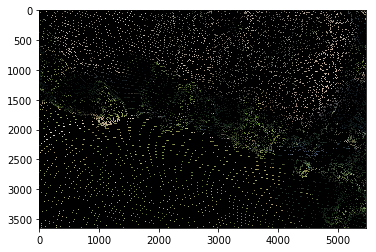

In [12]:
# plot image 
import matplotlib.pyplot as plt
plt.imshow(image)

# save the image
cv2.imwrite("../../data/box_canyon_export/high_sample_transformed.png", image)

True

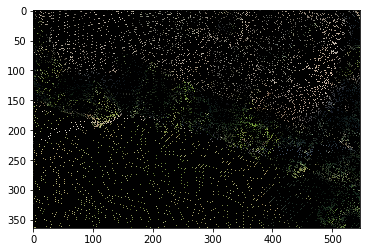

In [13]:
# resize the image by ratio
ratio = 0.1
height = int(image_height * ratio)
width = int(image_width * ratio)

image_resized = cv2.resize(image, (width, height), interpolation=cv2.INTER_NEAREST)
plt.imshow(image_resized)

# save the image
cv2.imwrite("../../data/box_canyon_export/high_sample_transformed_resized.png", image_resized)

In [14]:
mask = np.all(image_resized > 0, axis=2)

idxs = np.where(mask)
points_2d = np.vstack((idxs[0], idxs[1])).T

# Build a KD-tree for the 2D points
tree = KDTree(points_2d)

In [15]:
img = image_resized.copy()
height, width, _ = img.shape
for i in range(height):
    for j in range(width):
        if mask[i, j] == False:
            idx = tree.query_ball_point([i, j],r=3)
            if len(idx) == 0:
                continue
            else:
                u,v = points_2d[idx[0]]
                img[i, j] = img[u, v]

True

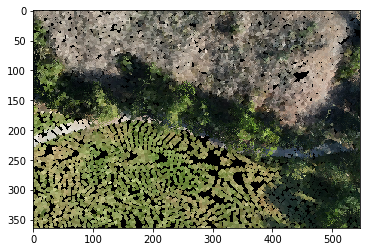

In [16]:
plt.imshow(img)

# save the image
cv2.imwrite("../../data/box_canyon_export/high_sample_transformed_resized_filled.png", img)

True

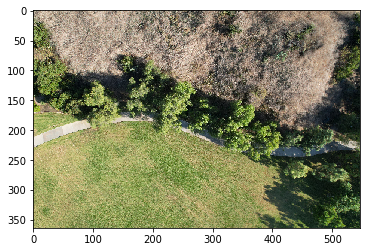

In [23]:
# read original image RGB
img_ori = cv2.imread("../../data/mission_2/DJI_0247.JPG", cv2.IMREAD_COLOR)
img_ori = cv2.cvtColor(img_ori, cv2.COLOR_RGB2BGR)

# resize the image by ratio
ratio = 0.1
height = int(image_height * ratio)
width = int(image_width * ratio)

img_ori_resized = cv2.resize(img_ori, (width, height), interpolation=cv2.INTER_NEAREST)
plt.imshow(img_ori_resized)

# save the image
cv2.imwrite("../../data/box_canyon_export/DJI_0247_resized.png", img_ori_resized)

# WebODM

In [3]:
las_file = "../../data/model.las"
points, colors = read_las_file(las_file)

In [5]:
camera_intrinsics_file = "../../data/camera.json"
camera_intrinsics, distortion_params = read_camera_intrinsics_webodm(camera_intrinsics_file)
print(camera_intrinsics)

camera_list_file = "../../data/shots.geojson"
cameras = read_camera_extrinsics_webodm(camera_list_file)
extrinsic_matrix = cameras['DJI_0247.JPG']
print(extrinsic_matrix)

image_height = cameras['height']
image_width = cameras['width']
print(image_height, image_width)

[[3.55241856e+03 0.00000000e+00 2.76411893e+03]
 [0.00000000e+00 3.55241856e+03 1.81903216e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-5.96660920e-01 -7.92497584e-01  1.26266887e-01  4.32761396e+05]
 [-8.01918877e-01  5.82853971e-01 -1.31176838e-01  3.74973891e+06]
 [ 3.03621710e-02 -1.79523893e-01 -9.83284959e-01  2.06044185e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
3648 5472


In [6]:
# Transform the point cloud using the extrinsic matrix
points_homogeneous = np.hstack((points, np.ones((len(points), 1))))

extrinsic_matrix_inv = np.linalg.inv(extrinsic_matrix)

points_transformed = np.matmul(points_homogeneous, extrinsic_matrix_inv.T)

# Project the points using the intrinsic matrix
# Drop the homogeneous component (w)
points_camera_space = points_transformed[:, :3]

In [7]:
# save the points to las file with colors
las = laspy.create(file_version="1.2", point_format=3)
las.x = points_camera_space[:, 0]
las.y = points_camera_space[:, 1]
las.z = points_camera_space[:, 2]
las.red = colors[:, 0]
las.green = colors[:, 1]
las.blue = colors[:, 2]
#las.intensity = colors[:, 3]   # intensity is used to store the alpha channel
las.write("../../data/model_transformed.las")   

In [10]:
points_projected = np.matmul(points_camera_space, camera_intrinsics.T)
points_projected /= points_projected[:, -1].reshape(-1, 1)

# Initialize image (2D array) and z-buffer
image = np.zeros((image_height, image_width, 3), dtype=np.uint8)
z_buffer = np.full((image_height, image_width), np.inf)

# Assuming points_projected and colors are NumPy arrays
x, y, z = points_projected.T
px, py = x.astype(int), y.astype(int)

# Create mask for valid points
valid_mask = (0 <= px) & (px < image_width) & (0 <= py) & (py < image_height)

# Filter points and colors based on the valid mask
valid_points = points_projected[valid_mask]
valid_colors = colors[valid_mask]
px, py, pz = valid_points.T
px, py = px.astype(int), py.astype(int)

# Updating Z-buffer and image
for i in range(len(valid_points)):
    if pz[i] < z_buffer[py[i], px[i]]:
        z_buffer[py[i], px[i]] = pz[i]
        image[py[i], px[i]] = valid_colors[i].astype(np.uint8)

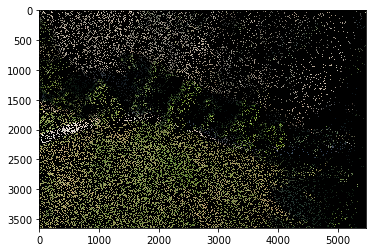

In [11]:
# plot image 
plt.imshow(image)

In [9]:
filtered_points = points_camera_space[points_flags]
filtered_colors = colors[points_flags]

# save filtered points to las file
las = laspy.create(file_version="1.2", point_format=3)
las.x = filtered_points[:, 0]
las.y = filtered_points[:, 1]
las.z = filtered_points[:, 2]
las.red = filtered_colors[:, 0]
las.green = filtered_colors[:, 1]
las.blue = filtered_colors[:, 2]
#las.intensity = colors[:, 3]   # intensity is used to store the alpha channel
las.write("../../data/model_transformed_projected.las")

In [13]:
# save the filtered points in the original pointcloud coordinate
filtered_points = points_camera_space[points_flags]
filtered_colors = colors[points_flags]

# Transform the point cloud using the extrinsic matrix
points_homogeneous = np.hstack((filtered_points, np.ones((len(filtered_points), 1))))

points_transformed = np.matmul(points_homogeneous, extrinsic_matrix.T )

# Drop the homogeneous component (w)
points_transformed = points_transformed[:, :3]

# save the points to las file with colors
las = laspy.create(file_version="1.2", point_format=3)
las.x = points_transformed[:, 0]
las.y = points_transformed[:, 1]
las.z = points_transformed[:, 2]
las.red = filtered_colors[:, 0]
las.green = filtered_colors[:, 1]
las.blue = filtered_colors[:, 2]
las.write("../../data/model_filtered.las")

True

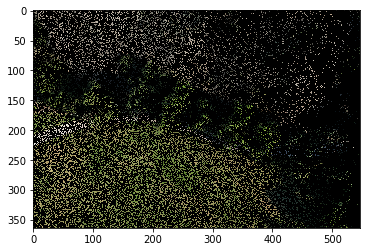

In [15]:
# resize the image by ratio
ratio = 0.1
height = int(image_height * ratio)
width = int(image_width * ratio)

image_resized = cv2.resize(image, (width, height), interpolation=cv2.INTER_NEAREST)
plt.imshow(image_resized)

# save the image
image_resized_ = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
cv2.imwrite("../../data/model_transformed_resized.png", image_resized_)

In [16]:
mask = np.all(image_resized > 0, axis=2)

idxs = np.where(mask)
points_2d = np.vstack((idxs[0], idxs[1])).T

# Build a KD-tree for the 2D points
tree = KDTree(points_2d)
img = image_resized.copy()
height, width, _ = img.shape
for i in range(height):
    for j in range(width):
        if mask[i, j] == False:
            idx = tree.query_ball_point([i, j],r=3)
            if len(idx) == 0:
                continue
            else:
                u,v = points_2d[idx[0]]
                img[i, j] = img[u, v]

True

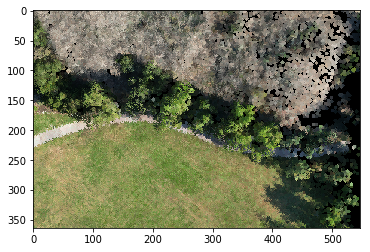

In [17]:
plt.imshow(img)

# save the image
img_ = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.imwrite("../../data/model_resized_filled.png", img_)

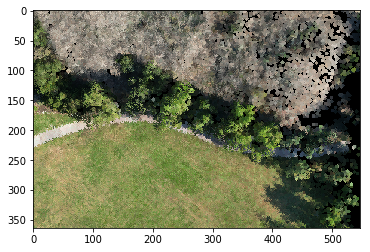

In [4]:
# read projected image
img_projected = cv2.imread("../../data/model_resized_filled.png", cv2.IMREAD_COLOR)

plt.imshow(img_projected)

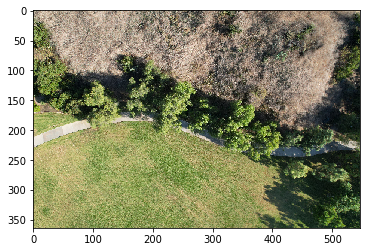

In [6]:
# read original image RGB
img_ori = cv2.imread("../../data/mission_2/DJI_0247.JPG", cv2.IMREAD_COLOR)
img_ori = cv2.cvtColor(img_ori, cv2.COLOR_RGB2BGR)

# resize the image by ratio
ratio = 0.1
height = int(image_height * ratio)
width = int(image_width * ratio)

img_ori_resized = cv2.resize(img_ori, (width, height), interpolation=cv2.INTER_NEAREST)
plt.imshow(img_ori_resized)


In [18]:
# given a pixel coordinate, draw a circle on the image
def draw_circle(img, x, y, radius=3, color=(255, 0, 0)):
    img = img.copy()
    cv2.circle(img, (x, y), radius, color, 2)
    return img


# plot two images side by side
def plot_images(img1, img2, title1="Image 1", title2="Image 2"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.imshow(img1)
    ax1.set_title(title1)
    ax2.imshow(img2)
    ax2.set_title(title2)
    plt.show()

# generate a random pixel coordinate in an image
def random_pixel_coordinates(img):
    height, width, _ = img.shape
    x = np.random.randint(0, width)
    y = np.random.randint(0, height)
    return x, y

# generate a random color
def random_color():
    return np.random.randint(0, 255, size=3).tolist()


def draw_random_circles(img1, img2, N):
    for _ in range(N):
        x, y = random_pixel_coordinates(img1)
        color = random_color()
        img1 = draw_circle(img1, x, y, color=color)
        img2 = draw_circle(img2, x, y, color=color)
    
    return img1, img2


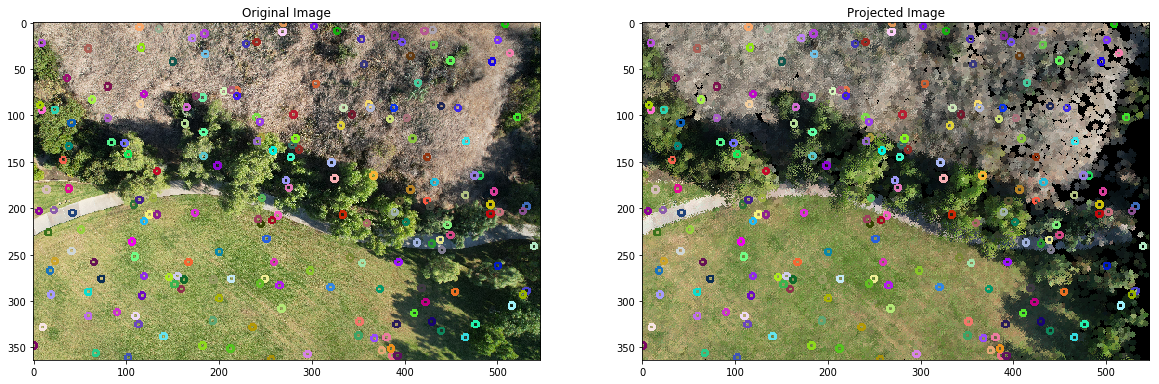

In [20]:
img1, img2 = draw_random_circles(img_ori_resized, img_projected, 200)   
plot_images(img1, img2, title1="Original Image", title2="Projected Image")

# Image distortion correction

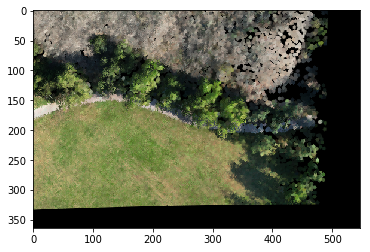

In [6]:
undistorted_image = cv2.undistort(img_projected, camera_intrinsics, distortion_params)

plt.imshow(undistorted_image)

**Conclusion:** Distortions are typically caused by lens manufacturing imperfections. When projecting a point cloud onto image planes, we use an ideal pinhole camera model, which assumes a perfect lens. Therefore, additional distortion correction is not necessary and will introduce problems.

# Efficiency Optimization

WebODM example

In [6]:
las_file = "../../data/model.las"
points, colors = read_las_file(las_file)

In [7]:
camera_intrinsics_file = "../../data/camera.json"
camera_intrinsics, distortion_params = read_camera_intrinsics_webodm(camera_intrinsics_file)
print(camera_intrinsics)

camera_list_file = "../../data/shots.geojson"
cameras = read_camera_extrinsics_webodm(camera_list_file)
extrinsic_matrix = cameras['DJI_0247.JPG']
print(extrinsic_matrix)

image_height = cameras['height']
image_width = cameras['width']
print(image_height, image_width)

[[3.55241856e+03 0.00000000e+00 2.76411893e+03]
 [0.00000000e+00 3.55241856e+03 1.81903216e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-5.96660920e-01 -7.92497584e-01  1.26266887e-01  4.32761396e+05]
 [-8.01918877e-01  5.82853971e-01 -1.31176838e-01  3.74973891e+06]
 [ 3.03621710e-02 -1.79523893e-01 -9.83284959e-01  2.06044185e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
3648 5472


In [8]:
# Transform the point cloud using the extrinsic matrix
points_homogeneous = np.hstack((points, np.ones((len(points), 1))))

extrinsic_matrix_inv = np.linalg.inv(extrinsic_matrix)

points_transformed = np.matmul(points_homogeneous, extrinsic_matrix_inv.T)

# Project the points using the intrinsic matrix
# Drop the homogeneous component (w)
points_camera_space = points_transformed[:, :3]

points_projected = np.matmul(points_camera_space, camera_intrinsics.T)
points_projected /= points_projected[:, -1].reshape(-1, 1)

### for iteration (benchmark)

In [16]:
t1 = time.time()

# Initialize image (2D array) and z-buffer
image = np.zeros((image_height, image_width, 3), dtype=np.uint8)
z_buffer = np.full((image_height, image_width), np.inf)
associations = {}

points_flags = []
# Iterate through each point
for point, color in zip(points_projected, colors):
    x, y, z = point[:3]

    # Convert to pixel coordinates
    px, py = int(x), int(y)

    # Check if the point is within the image bounds
    if 0 <= px < image_width and 0 <= py < image_height:
        # Update the pixel if this point is closer to the camera
        if z < z_buffer[py, px]:
            z_buffer[py, px] = z
            image[py, px] = (np.array(color)).astype(np.uint8)

        points_flags.append(True)

    else:
        points_flags.append(False)

t2 = time.time()
print("Time elapsed: ", t2-t1)

for_loop_time = t2-t1

Time elapsed:  68.01858377456665


### Numpy vectorization 

In [17]:
t1 = time.time()

# Initialize image (2D array) and z-buffer
image = np.zeros((image_height, image_width, 3), dtype=np.uint8)
z_buffer = np.full((image_height, image_width), np.inf)

# Dictionary for storing associations
associations = {}

# Assuming points_projected and colors are NumPy arrays
x, y, z = points_projected.T
px, py = x.astype(int), y.astype(int)

t2 = time.time()
print("Time elapsed: ", t2-t1)

# Create mask for valid points
valid_mask = (0 <= px) & (px < image_width) & (0 <= py) & (py < image_height)

t3 = time.time()
print("Time elapsed: ", t3-t2)

# Filter points and colors based on the valid mask
valid_points = points_projected[valid_mask]
valid_colors = colors[valid_mask]
px, py, pz = valid_points.T
px, py = px.astype(int), py.astype(int)

t4 = time.time()
print("Time elapsed: ", t4-t3)

# Updating Z-buffer, image, and creating associations
for i in range(len(valid_points)):
    if pz[i] < z_buffer[py[i], px[i]]:
        z_buffer[py[i], px[i]] = pz[i]
        image[py[i], px[i]] = valid_colors[i].astype(np.uint8)

        # Add association
        # Map from 3D point (tuple) to 2D pixel coordinates (tuple)
        associations[tuple(valid_points[i])] = (px[i], py[i])

t5 = time.time()
print("Time elapsed: ", t5-t4)
print("Total time elapsed: ", t5-t1)

numpy_vectorized_time = t5-t1

Time elapsed:  0.29798269271850586
Time elapsed:  0.11401820182800293
Time elapsed:  0.34662508964538574
Time elapsed:  23.50340175628662
Total time elapsed:  24.262027740478516


### Pytorch implementation

In [20]:
# need to check which GPU is available
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [ ]:
t1 = time.time()

image = torch.zeros((image_height, image_width, 3), dtype=torch.uint8, device=device)
z_buffer = torch.full((image_height, image_width), float('inf'), device=device)

# Assuming points_projected and colors are numpy arrays
# Convert them to PyTorch tensors and transfer to GPU
points_projected = torch.tensor(points_projected, device=device)
colors = torch.tensor(colors.astype(np.uint8), device=device)

# Decompose points_projected to x, y, z coordinates
x, y, z = points_projected.unbind(-1)
px, py = x.long(), y.long()

# Create mask for valid points
valid_mask = (0 <= px) & (px < image_width) & (0 <= py) & (py < image_height)

# Filter points and colors based on the valid mask
valid_points = points_projected[valid_mask]
valid_colors = colors[valid_mask]
px, py, pz = valid_points.unbind(-1)
px, py = px.long(), py.long()

# Initialize associations as a list (due to variable sizes, can't be a tensor)
associations = []

# Updating Z-buffer, image, and creating associations
for i in range(valid_points.size(0)):
    if pz[i] < z_buffer[py[i], px[i]]:
        z_buffer[py[i], px[i]] = pz[i]
        image[py[i], px[i]] = valid_colors[i]

        # Add association
        associations.append((valid_points[i].cpu().numpy(), (px[i].item(), py[i].item())))

# Convert final image back to numpy for visualization or saving
final_image = image.cpu().numpy()

t2 = time.time()
print("Time elapsed: ", t2-t1)

pytorch_time = t2-t1

Too long to run

**Conclusion:** There are two reasons that pytorch implementation is slow. (1) Data transfering overhead. (2) The most time consuming part in numpy vectorization is the for loop iteration. GPU is usually much slower at for loop iteration than CPU. 

### Numba implementation

In [22]:
# association only on valid points 

@jit(nopython=True)
def update_image(image, z_buffer, points, colors, associations):
    height, width = image.shape[:2]
    for i in range(points.shape[0]):
        x, y, z = points[i]
        color = colors[i]
        px, py = int(x), int(y)

        if 0 <= px < width and 0 <= py < height:
            if z < z_buffer[py, px]:
                z_buffer[py, px] = z
                image[py, px] = color
                associations[i] = (px, py)
    return image, z_buffer, associations

t1 = time.time()

image = np.zeros((image_height, image_width, 3), dtype=np.uint8)
z_buffer = np.full((image_height, image_width), np.inf)

# Assuming points_projected and colors are NumPy arrays
x, y, z = points_projected.T
px, py = x.astype(int), y.astype(int)

# Create mask for valid points
valid_mask = (0 <= px) & (px < image_width) & (0 <= py) & (py < image_height)

# Filter points and colors based on the valid mask
valid_points = points_projected[valid_mask]
valid_colors = colors[valid_mask]
px, py, pz = valid_points.T
px, py = px.astype(int), py.astype(int)

# Prepare associations array
associations = np.empty((len(valid_points), 2), dtype=np.int32)

# Update image using Numba-optimized function
image, z_buffer, associations = update_image(image, z_buffer, valid_points, valid_colors, associations)

t2 = time.time()
print("Time elapsed: ", t2-t1)

# Process associations
associations_dict = {tuple(valid_points[i]): (associations[i, 0], associations[i, 1]) for i in range(len(valid_points))}

t3 = time.time()
print("Time elapsed: ", t3-t2)
print("Total time elapsed: ", t3-t1)

Time elapsed:  1.315514326095581
Time elapsed:  11.945154666900635
Total time elapsed:  13.260668992996216


In [18]:
# association on all points

@jit(nopython=True)
def update_image_and_associations(image, z_buffer, points, colors, height, width):
    # Initialize an array for associations with the same length as points array
    associations = np.full((points.shape[0], 2), -1, dtype=np.int32)  # -1 indicates no valid association

    for i in range(points.shape[0]):
        x, y, z = points[i]
        color = colors[i]
        px, py = int(x), int(y)

        if 0 <= px < width and 0 <= py < height:
            if z < z_buffer[py, px]:
                z_buffer[py, px] = z
                image[py, px] = color
                associations[i] = [px, py]

    return image, z_buffer, associations

t1 = time.time()

# Initialize image (2D array) and z-buffer
image = np.zeros((image_height, image_width, 3), dtype=np.uint8)
z_buffer = np.full((image_height, image_width), np.inf)

# Assuming points_projected and colors are NumPy arrays
x, y, z = points_projected.T
px, py = x.astype(int), y.astype(int)

# Update image and get associations
image, z_buffer, associations = update_image_and_associations(image, z_buffer, points_projected, colors, image_height, image_width)

t2 = time.time()
print("Time elapsed: ", t2-t1)

numba_time = t2-t1

Time elapsed:  3.7348792552948


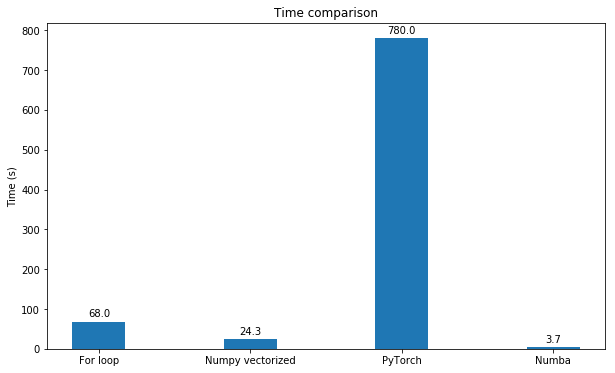

In [25]:
labels = ['For loop', 'Numpy vectorized', 'PyTorch', 'Numba']
times = [for_loop_time, numpy_vectorized_time, pytorch_time, numba_time]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects = ax.bar(x, times, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_title('Time comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Function to attach a text label above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.1f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

plt.show()